# Prediciendo el Valor de Inmuebles en Bogotá
En este notebook se encontrarán con un breve repaso de limpieza de datos y aplicación de modelos predictivos de machine learning. Los datos elegidos han sido extraidos de la pagina oficial de metrocuadrado a través de tecnicas de webscraping

Para desarrollar este trabajo se requerirán de las siguientes librerias:

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [92]:
datos = pd.read_csv('https://drive.google.com/uc?id=1jwQo5QLpdgfjqi17NV3t_nt6t8uuERgJ')

### Un breve vistazo a las variables.

Se identifica que no hay presencia de valores nulosl, sin embargo, es importante analizar las variables de tipo objeto, esto puede significar que contienen variables tipo string y que posiblemente contengan en primera instancia una secuencia de valores en diferente formato.


In [93]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          10000 non-null  int64  
 1   mtipoinmueble       10000 non-null  object 
 2   mvalorventa         10000 non-null  int64  
 3   marea               10000 non-null  float64
 4   mnrocuartos         9993 non-null   object 
 5   mnrobanos           10000 non-null  object 
 6   mnrogarajes         9945 non-null   float64
 7   mzona               9812 non-null   object 
 8   mbarrio             9945 non-null   object 
 9   mnombrecomunbarrio  9866 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 781.4+ KB


#### Tipo de inmueble:
Se considera una variable categorica, por tanto, se procede a realizar el cast al tipo de dato.

In [94]:
datos['mtipoinmueble'] = datos.mtipoinmueble.astype('category')

#### Nombre comun barrio:
Se considera una variable categorica, por tanto, se procede a realizar el cast al tipo de dato.

In [95]:
datos['mnombrecomunbarrio'] = datos.mnombrecomunbarrio.astype('category')

#### Barrio:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable.

In [96]:
datos['mbarrio']= datos.mbarrio.astype('category')

#### Zona:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable.

In [97]:
datos['mzona'] = datos.mzona.astype('category')

#### Numero Cuartos:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable, sin embargo, para esta variable es necesario realizar una ligera modificación a ciertos valores que estan siendo interpretados como Strings antes de realizar la conversión de las variables.

In [98]:
datos['mnrocuartos'] = datos.mnrocuartos.apply(lambda x: 6 if x == '5+' else x).astype(float)

#### Numero Baños:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable, sin embargo, para esta variable es necesario realizar una ligera modificación a ciertos valores que estan siendo interpretados como Strings antes de realizar la conversión de las variables.

In [99]:
datos['mnrobanos'] = datos.mnrobanos.apply(lambda x: 6 if x == '5+' else x).astype(float)

In [100]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          10000 non-null  int64   
 1   mtipoinmueble       10000 non-null  category
 2   mvalorventa         10000 non-null  int64   
 3   marea               10000 non-null  float64 
 4   mnrocuartos         9993 non-null   float64 
 5   mnrobanos           10000 non-null  float64 
 6   mnrogarajes         9945 non-null   float64 
 7   mzona               9812 non-null   category
 8   mbarrio             9945 non-null   category
 9   mnombrecomunbarrio  9866 non-null   category
dtypes: category(4), float64(4), int64(2)
memory usage: 577.3 KB


## Visualización de los Datos
Para comprender la distrubución de los datos, 

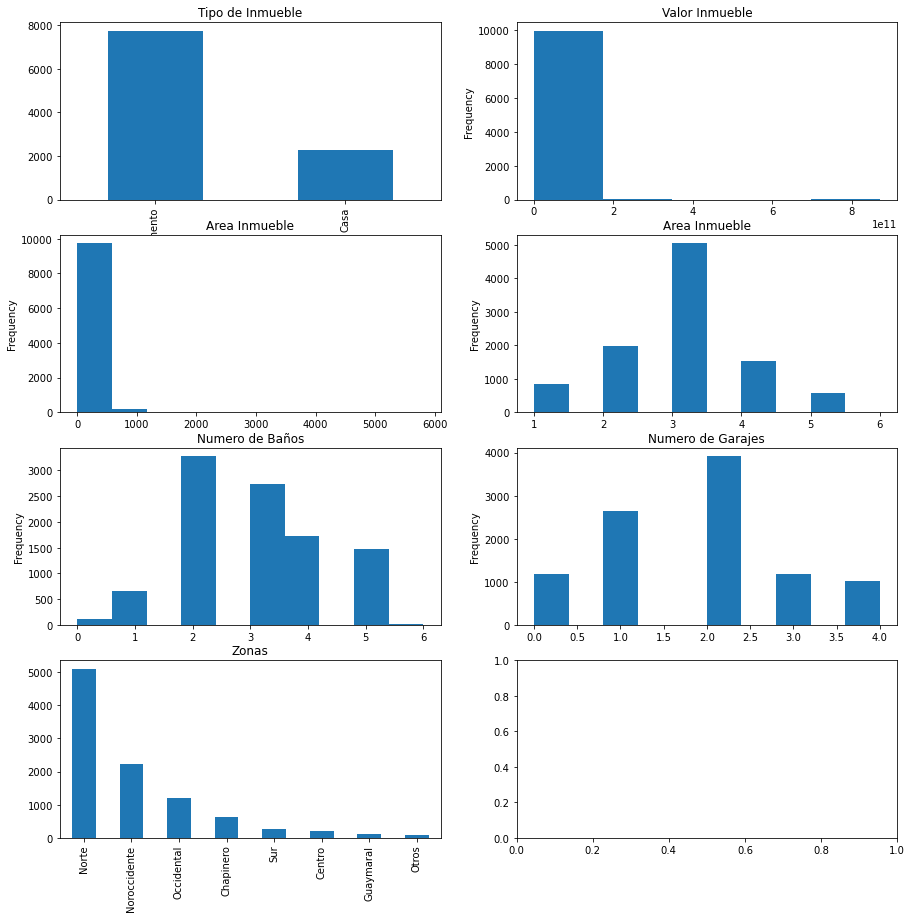

In [101]:
fig,ax = plt.subplots(4,2,figsize = (15,15))
datos.mtipoinmueble.value_counts().plot.bar(ax = ax[0,0],title = 'Tipo de Inmueble')
datos.mvalorventa.plot.hist(ax = ax[0,1],bins=5,title = 'Valor Inmueble')
datos.marea.plot.hist(ax = ax[1,0],title = 'Area Inmueble')
datos.mnrocuartos.plot.hist(ax = ax[1,1],title = 'Area Inmueble')
datos.mnrobanos.plot.hist(ax = ax[2,0],title = 'Numero de Baños')
datos.mnrogarajes.plot.hist(ax = ax[2,1],title = 'Numero de Garajes')
datos.mzona.value_counts().plot.bar(ax = ax[3,0],title = 'Zonas')
plt.show()

Es evidente que la variable area del inmueble tiene un fuerte sesgo hacia la izquierda, ocasionando que los datos no se aprecien completamente, por tanto, se decide realizar una conversión con log natural a los datos de la variable como se evidencia a continuación:

In [113]:
datos['mvalorventa_log'] = datos.mvalorventa.apply(np.log10)
datos['marea_log'] = (datos.marea + 1).apply(np.log10)

Sin embargo la conversión no elimina los outliers, es necesario eliminarlos realizando un filtro a la variable

Text(0.5, 0, 'log en base 10 del Area')

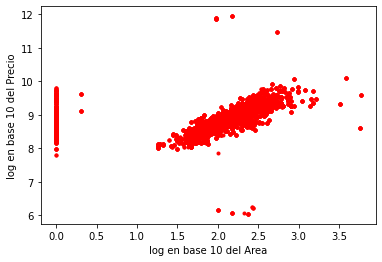

In [114]:
plt.plot(datos['marea_log'],datos['mvalorventa_log'],'r.')
plt.ylabel('log en base 10 del Precio')
plt.xlabel('log en base 10 del Area')

In [115]:
filtro = ((datos.marea_log < 0.5) | 
          (datos.marea_log > 3.5) | 
          (datos.mvalorventa_log < 7) | 
          (datos.mvalorventa_log > 11))

filtro2 = datos_sin_outliers.mvalorventa_log < 7.9

# El simbolo ~ significa no
datos_sin_outliers = datos[~filtro]
datos_sin_outliers = datos_sin_outliers[~filtro2]


Text(0.5, 0, 'log en base 10 del Area')

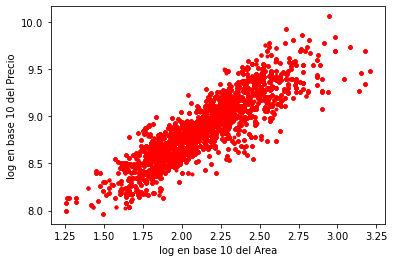

In [116]:
plt.plot(datos_sin_outliers['marea_log'], datos_sin_outliers['mvalorventa_log'], 'r.')
plt.ylabel('log en base 10 del Precio')
plt.xlabel('log en base 10 del Area')

In [118]:
df = datos_sin_outliers.drop_duplicates()

Text(0.5, 0, 'Area ($m^2$)')

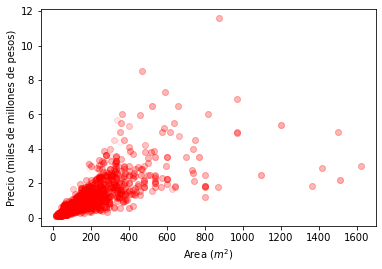

In [124]:
plt.plot(df['marea'], df['mvalorventa']/1e9, 'ro',alpha=0.05)
plt.ylabel('Precio (miles de millones de pesos)')
plt.xlabel('Area ($m^2$)')